***
## notebook config

In [1]:
ON_COLAB = False
ASSESS = True

In [2]:
if ON_COLAB:
    from google.colab import drive
    from google.colab import files
    drive.mount('/content/drive', force_remount=True)
    
    !pip install --upgrade kaggle > /dev/null 2>&1
    !mkdir -p ~/.kaggle/ && cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
    
    !free -h
    
    !pip install --upgrade category_encoders > /dev/null 2>&1
    !pip install --upgrade tsforest > /dev/null 2>&1
    !pip install --upgrade lightgbm > /dev/null 2>&1
    !pip install --upgrade optuna > /dev/null 2>&1

In [3]:
if ON_COLAB:
    !kaggle datasets download -d mavillan/meli-2021 --force --unzip
    !ls -halt
    input_path = "./"
    print("input_path:", input_path)
    subs_path = "/content/drive/MyDrive/meli2021/subs"
    print("subs_path:", subs_path)
    results_path = "/content/drive/MyDrive/meli2021/results"
    print("results_path:", results_path)
else:
    input_path = "../data"
    print("input_path:", input_path)
    subs_path = "../subs"
    print("subs_path:", subs_path)
    results_path = "../results"
    print("results_path:", results_path)

input_path: ../data
subs_path: ../subs
results_path: ../results


***

In [4]:
from copy import deepcopy
import gc
import dill
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time
from tqdm import tqdm
import yaml
import shap

from sklearn import preprocessing
import category_encoders as ce
import lightgbm as lgb
from tsforest.forecast import LightGBMForecaster

import sys
sys.path.append("../utils")
from memory import reduce_mem_usage
from metrics import RMSSE, ranked_probability_score, scoring_function, binarize_predictions
from inventory import InventoryDaysPredictor
from features import Featurador


In [5]:
SEED = 19
SUB_NBR = str(max([int(fn.split("/")[-1].split(".")[0][3:]) for fn in glob(f"{subs_path}/*")])+1)
print(SUB_NBR)

23


In [6]:
np.random.seed(SEED)
pd.set_option('display.max_columns', None)

***
## loading data for assessment

In [7]:
with open(f"../data/skus_assess_m1.yaml", "r") as file:
    skus_assess_m1 = yaml.load(file, Loader=yaml.FullLoader)
    print(f"len(skus_assess_m1): {len(skus_assess_m1)}")
    file.close()

with open(f"../data/skus_assess_m2.yaml", "r") as file:
    skus_assess_m2 = yaml.load(file, Loader=yaml.FullLoader)
    print(f"len(skus_assess_m2): {len(skus_assess_m2)}")
    file.close()
    
skus_for_test = pd.read_csv(f"{input_path}/test_data.csv").sku.values
print(f"len(skus_for_test): {len(skus_for_test)}")

len(skus_assess_m1): 482635
len(skus_assess_m2): 272130
len(skus_for_test): 551472


In [8]:
if ASSESS:
    scales = pd.read_csv(f"{input_path}/scales.csv")

    dataset = (
        pd.read_parquet(f"{input_path}/train-m1.parquet")
        .query("sku in @skus_assess_m1")
        .rename({"date":"ds", "sold_quantity":"y"}, axis=1,)
        .sort_values(["sku","ds"])
        .reset_index(drop=True)
    )
    
    with open("../encoders/encoder-stg1.dill", "rb") as file:
        encoder = dill.load(file)
        file.close()
    
    transformed = encoder.transform(dataset[encoder.cols].astype("category"))
    for col in transformed.columns:
        dataset[col+"_glm"] = transformed[col].values

In [9]:
if ASSESS:
    raw = pd.read_parquet(f"{input_path}/train_data.parquet", columns=["sku", "date", "sold_quantity", "minutes_active"])
    metadata = pd.read_csv(f"{input_path}/metadata.csv", usecols=["sku","item_domain_id","site_id"])
    raw = pd.merge(raw, metadata, how="inner", on="sku")

    # compute q_mean and q_std features (w/o leakage)
    feat = Featurador(raw)
    feat.fit(left_limit="2021-02-01", right_limit="2021-03-01")
    dataset = feat.transform(dataset)

In [10]:
with open(f"../config/dist_hparams.yml", "r") as file:
    dist_config = yaml.load(file, Loader=yaml.FullLoader)
    file.close()

print(dist_config)

{'lambda1': 1.6842502030985615, 'lambda2': 0.3677507495760691, 'lambda3': 0.5635636515917665, 'lambda4': 0.022595175543313962}


In [11]:
min_weight = 0.1
scaler = preprocessing.MinMaxScaler(feature_range=(min_weight, 1))
dataset["weight"] = scaler.fit_transform(dataset["minutes_active"].values.reshape(-1,1)).ravel()

***
## model config

In [12]:
categorical_features = {
    "listing_type": "default",
    "shipping_logistic_type": "default",
    "shipping_payment": "default",
    "item_domain_id": "default",
    "item_domain_id_glob": "default",
    "site_id":"default",
    "product_id_glob": "default",
    "product_family_id_glob": "default",
}

exclude_features = [
    "fold",
    "sold_quantity",
    "sku",
    "item_id",
    "minutes_active",
    "product_id",
    "product_id_glm",
    "product_family_id",
    "product_family_id_glm",
]

model_params = {
    'objective':'tweedie',
    'tweedie_variance_power':1.,
    'metric':'None',
    'num_iterations':1000,
    'max_bin': 63,
    'bin_construct_sample_cnt':20000000,
    'num_leaves': 2**8-1,
    'min_data_in_leaf': 2**8-1,
    'learning_rate': 0.01,
    'max_delta_step':1.,
    'feature_fraction':0.8,
    'bagging_fraction':0.8,
    'bagging_freq':1,
    'lambda_l2':0.1,
    'max_cat_threshold': 64,
    'cat_l2': 50,
    'cat_smooth': 50,
    'boost_from_average': False,
    'force_row_wise': True,
    'deterministic':True,
    'seed':SEED,
}
time_features = [
    "week_day",
    "week_day_cos",
    "week_day_sin",
    "month_progress",
]
model_kwargs = {
    "model_params":model_params,
    "time_features":time_features,
    "exclude_features":exclude_features,
    "categorical_features":categorical_features,
    "ts_uid_columns":["sku",],
    #"lags": [1,],
    #"window_functions":{
    #    "mean":   (None, [1,], [3,7,]),
    #    "std":    (None, [1,], [3,7]),
    #},
}

***
## model training: assessment

Mem. usage decreased to 1656.27 Mb (46.1% reduction)
Mem. usage decreased to 1726.04 Mb (46.1% reduction)
Elapsed time for processing features: 3.0870834469795225 min.
[LightGBM] [Info] Total Bins 40522
[LightGBM] [Info] Number of data points in the train set: 13893795, number of used features: 21
Training until validation scores don't improve for 30 rounds
[20]	valid_0's rmsse: 1.0794
[40]	valid_0's rmsse: 1.02046
[60]	valid_0's rmsse: 0.977173
[80]	valid_0's rmsse: 0.946247
[100]	valid_0's rmsse: 0.924518
[120]	valid_0's rmsse: 0.909668
[140]	valid_0's rmsse: 0.899824
[160]	valid_0's rmsse: 0.89356
[180]	valid_0's rmsse: 0.889681
[200]	valid_0's rmsse: 0.887425
[220]	valid_0's rmsse: 0.886373
[240]	valid_0's rmsse: 0.88606
[260]	valid_0's rmsse: 0.886357
Early stopping, best iteration is:
[239]	valid_0's rmsse: 0.886048


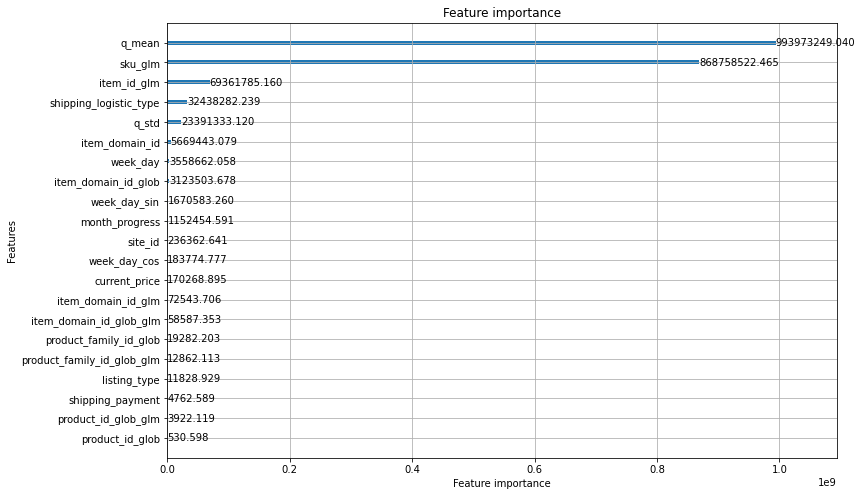

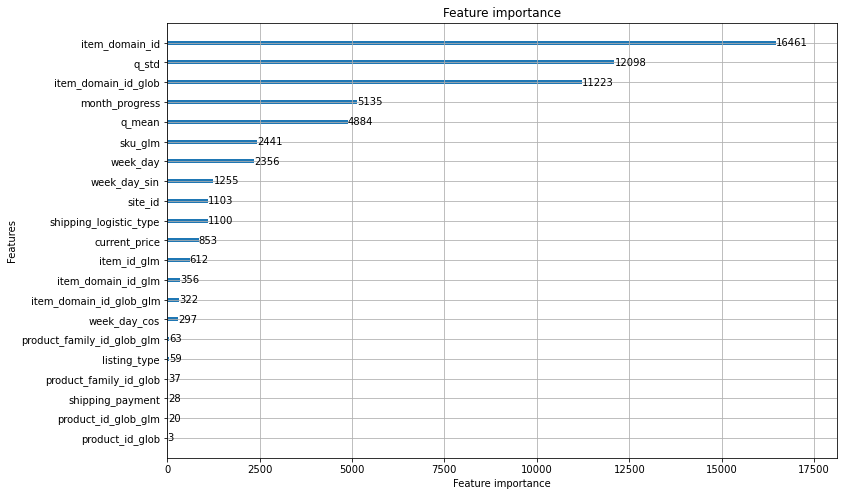

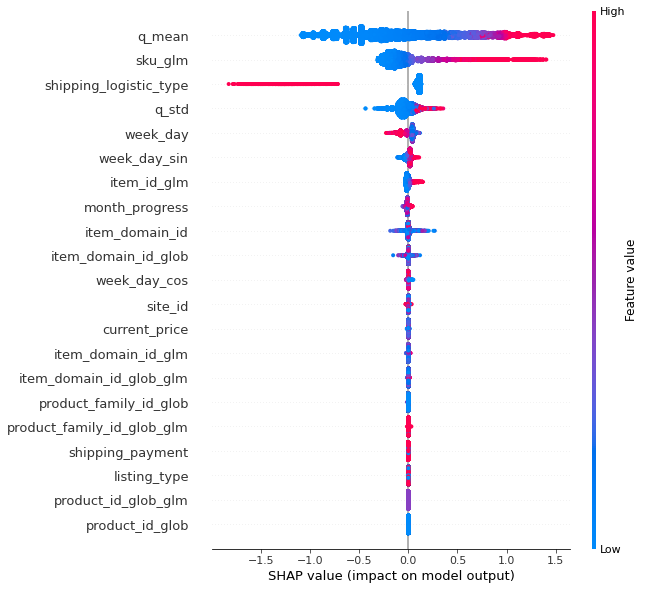

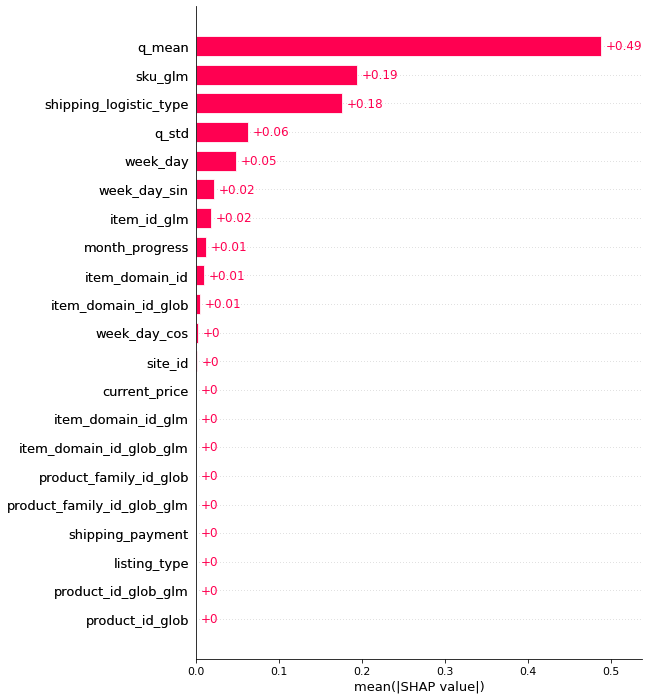

Elapsed time for training the model: 10.785877434412638 min.


In [13]:
if ASSESS:
    
    tic = time.time()
    train_data = dataset.copy()
    valid_idx = train_data.query("ds > '2021-03-01'").index

    model = LightGBMForecaster(**model_kwargs)
    model.prepare_features(train_data, valid_idx)
    model.train_features = reduce_mem_usage(model.train_features, verbose=True)
    model.valid_features = reduce_mem_usage(model.valid_features, verbose=True)
    gc.collect()
    tac = time.time()
    print(f"Elapsed time for processing features: {(tac-tic)/60} min.")


    tic = time.time()
    evaluator = RMSSE(train_data.loc[valid_idx, ["sku","y"]], scales)
    model.fit(fit_kwargs={"verbose_eval":20, "feval":evaluator.evaluate})

    lgb.plot_importance(model.model.model, figsize=(12,8), importance_type="gain")
    lgb.plot_importance(model.model.model, figsize=(12,8), importance_type="split")
    plt.show()
    explainer = shap.Explainer(model.model.model)
    shap_values = explainer(model.valid_features[model.input_features].sample(30000))
    shap.plots.beeswarm(shap_values, max_display=23, show=True)
    shap.plots.bar(shap_values, max_display=23, show=True)

    tac = time.time()
    print(f"Elapsed time for training the model: {(tac-tic)/60} min.")

In [14]:
%%time
    
if ASSESS:
    oof = model.predict(dataset.query("ds > '2021-03-01'"), recursive=False)

CPU times: user 9min 7s, sys: 23.6 s, total: 9min 31s
Wall time: 2min 20s


In [15]:
if ASSESS:
    mrg = pd.merge(oof, dataset.loc[:,["ds","sku","site_id","y"]], how="inner", on=["ds","sku"])
    mrg["sq_error"] = mrg.eval("(y-y_pred)**2")
    valid_errors = np.sqrt(mrg.groupby(["sku","site_id"])["sq_error"].mean()).reset_index(name="rmse")
    valid_errors = pd.merge(valid_errors, scales, how="inner", on="sku")
    valid_errors["rmsse"] = valid_errors.eval("rmse/scale")
    display(valid_errors.groupby("site_id")["rmsse"].mean())

site_id
MLA    0.843297
MLB    0.898222
MLM    0.879978
Name: rmsse, dtype: float64

In [16]:
if ASSESS:
    oof.to_csv(f"{results_path}/oof_preds_lgbm-m1.csv", index=False)

***
## Assessment of invetory days prediction

In [17]:
if ASSESS:
    if "oof" not in locals():
        oof = pd.read_csv("../results/oof_preds_lgbm-m1.csv")
        
    predictor = InventoryDaysPredictor(dataset.query("ds <= '2021-03-01'"))
    predictor.fit(oof)

100%|██████████| 482635/482635 [01:30<00:00, 5360.16it/s]


In [18]:
if ASSESS:
    valid = (
        pd.read_csv(f"{input_path}/validation_seed2_harder.csv")
        .query("sku in @skus_assess_m1")
        .reset_index(drop=True)
    )

    preds = list()
    for sku,df in tqdm(valid.groupby("sku")):
        preds.append(predictor.predict(sku, df.target_stock.values[0])[0])
        
    valid["days_to_stockout"] = np.asarray(preds)
    valid["days_to_stockout_disc"] = valid["days_to_stockout"].astype(int)

100%|██████████| 482635/482635 [01:17<00:00, 6193.95it/s]


RMSE (mean):  9.662950963293937
MAE (mean):  7.174033506510011
MAE (median):  5.169897218583945



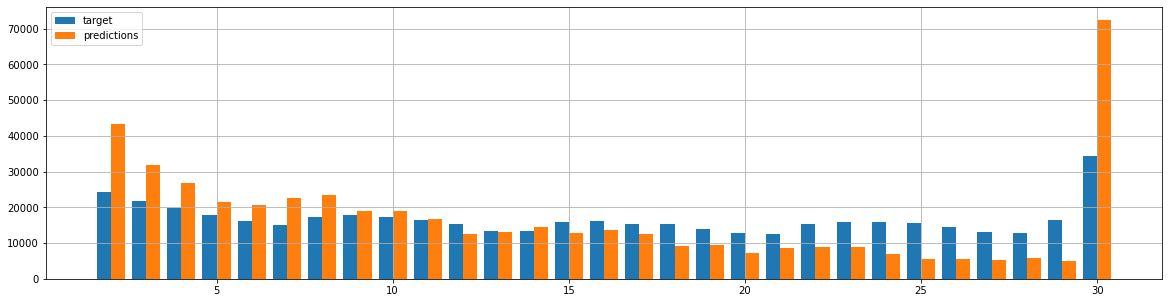

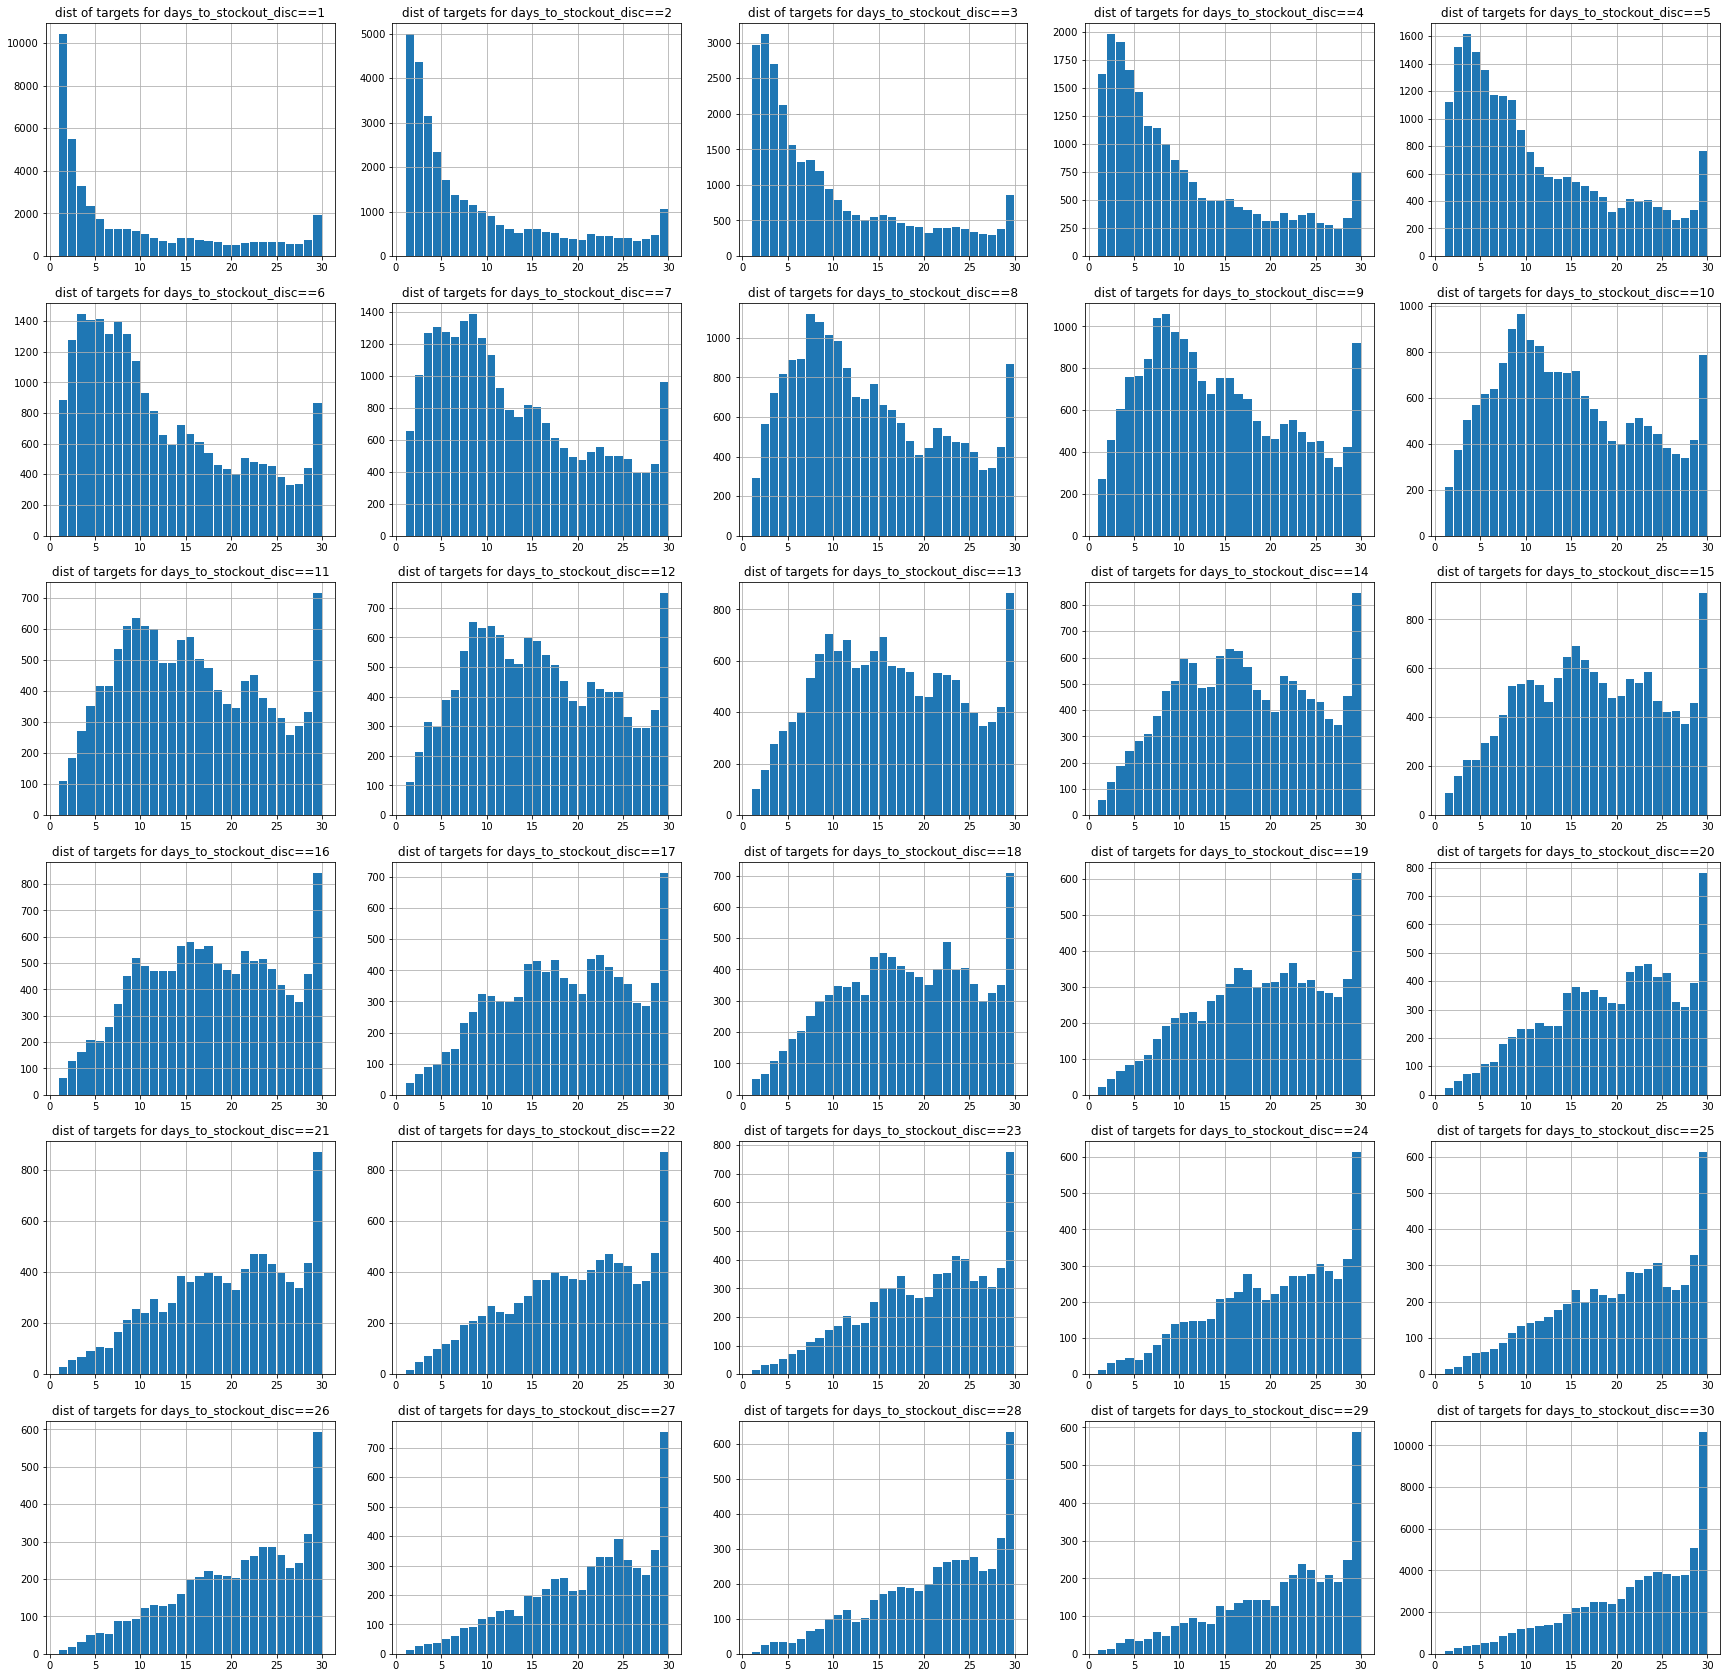

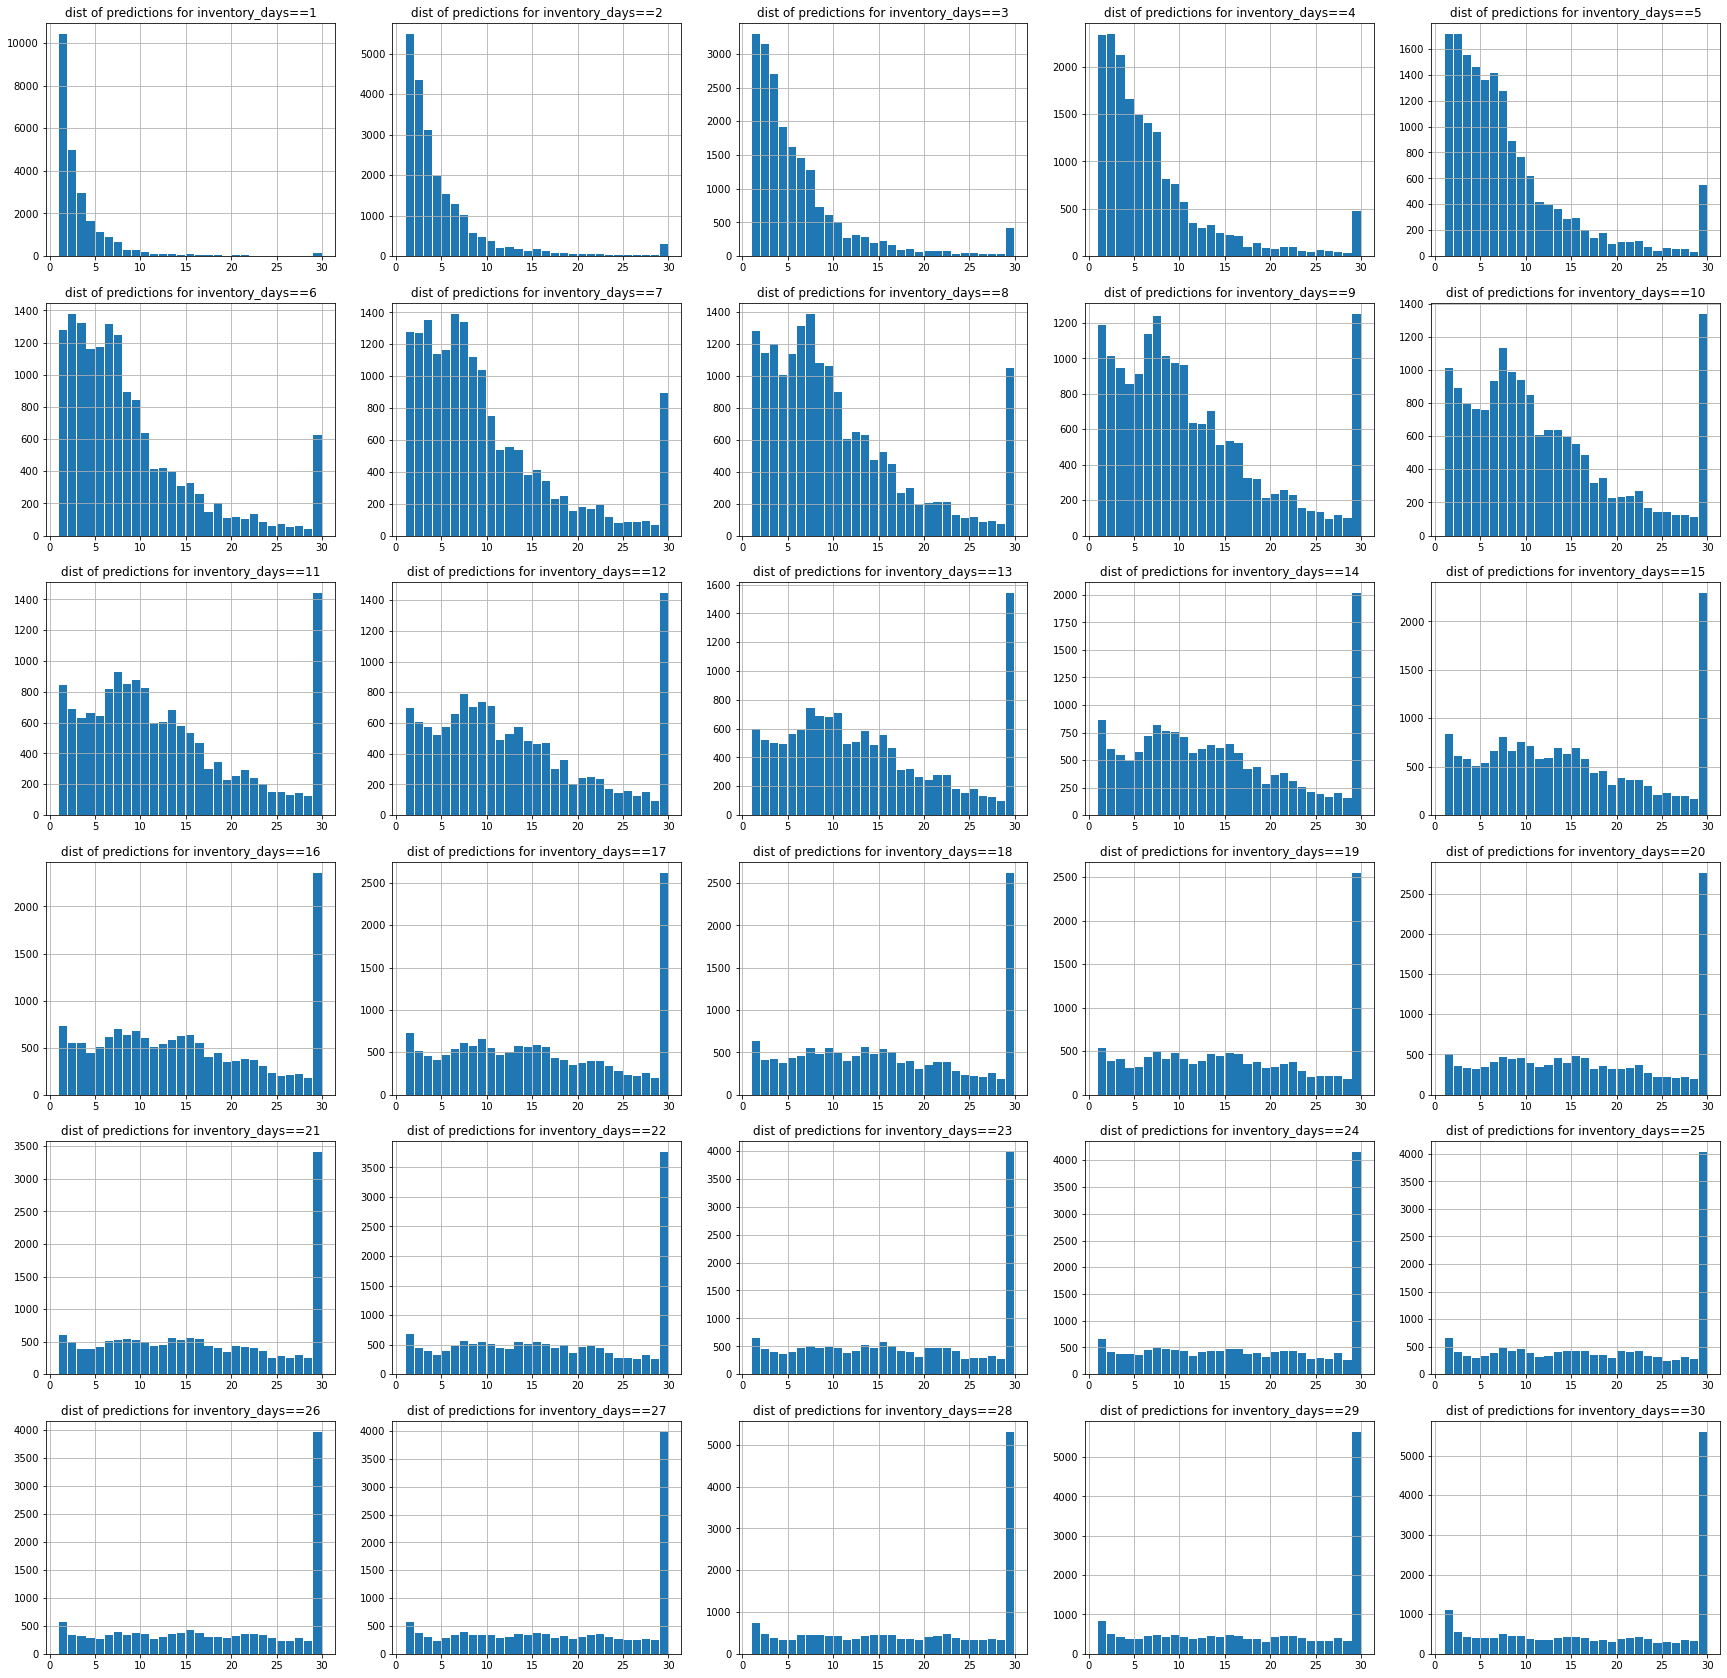

In [19]:
if ASSESS:
    print("RMSE (mean): ", np.sqrt(valid.query("inventory_days <= 31").eval("(days_to_stockout - inventory_days)**2").mean()) )
    print("MAE (mean): ",  valid.query("inventory_days <= 31").eval("abs(days_to_stockout - inventory_days)").mean() )
    print("MAE (median): ", valid.query("inventory_days <= 31").eval("abs(days_to_stockout - inventory_days)").median() )
    print()
    
    plt.figure(figsize=(20,5))
    plt.hist(
        [valid.query("inventory_days <= 31").inventory_days, 
         valid.query("inventory_days <= 31").days_to_stockout,
        ],
        label=["target","predictions"],
        bins=np.arange(1,31,1),
        align="right",
        rwidth=0.8)
    plt.legend(loc="best")
    plt.grid()
    plt.show()
    print()
    
    plt.figure(figsize=(30,30))
    for d in range(1,31):
        plt.subplot(6, 5, d)
        plt.hist(valid.query("days_to_stockout_disc==@d").inventory_days, bins=np.arange(1,31,1), rwidth=0.9)
        plt.title(f"dist of targets for days_to_stockout_disc=={d}")
        plt.grid()
    plt.show()
    print()
    
    plt.figure(figsize=(30,30))
    for d in range(1,31):
        plt.subplot(6, 5, d)
        plt.hist(valid.query("inventory_days==@d").days_to_stockout, bins=np.arange(1,31,1), rwidth=0.9)
        plt.title(f"dist of predictions for inventory_days=={d}")
        plt.grid()
    plt.show()

RMSE (mean):  8.930065202972012
MAE (mean):  6.6654758510563274
MAE (median):  4.977609360798919



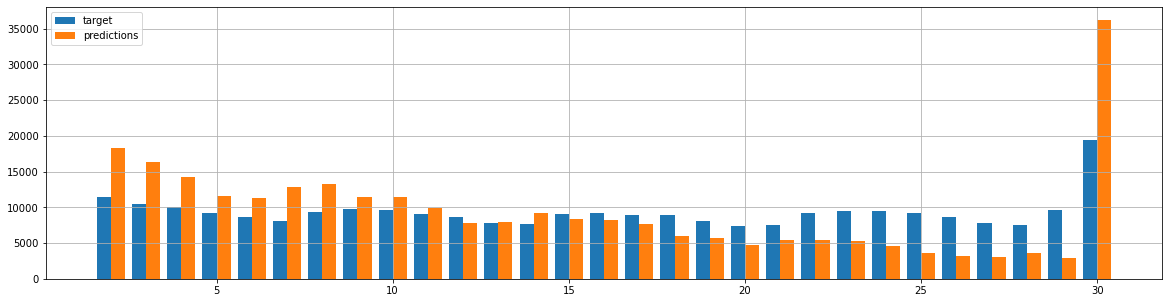

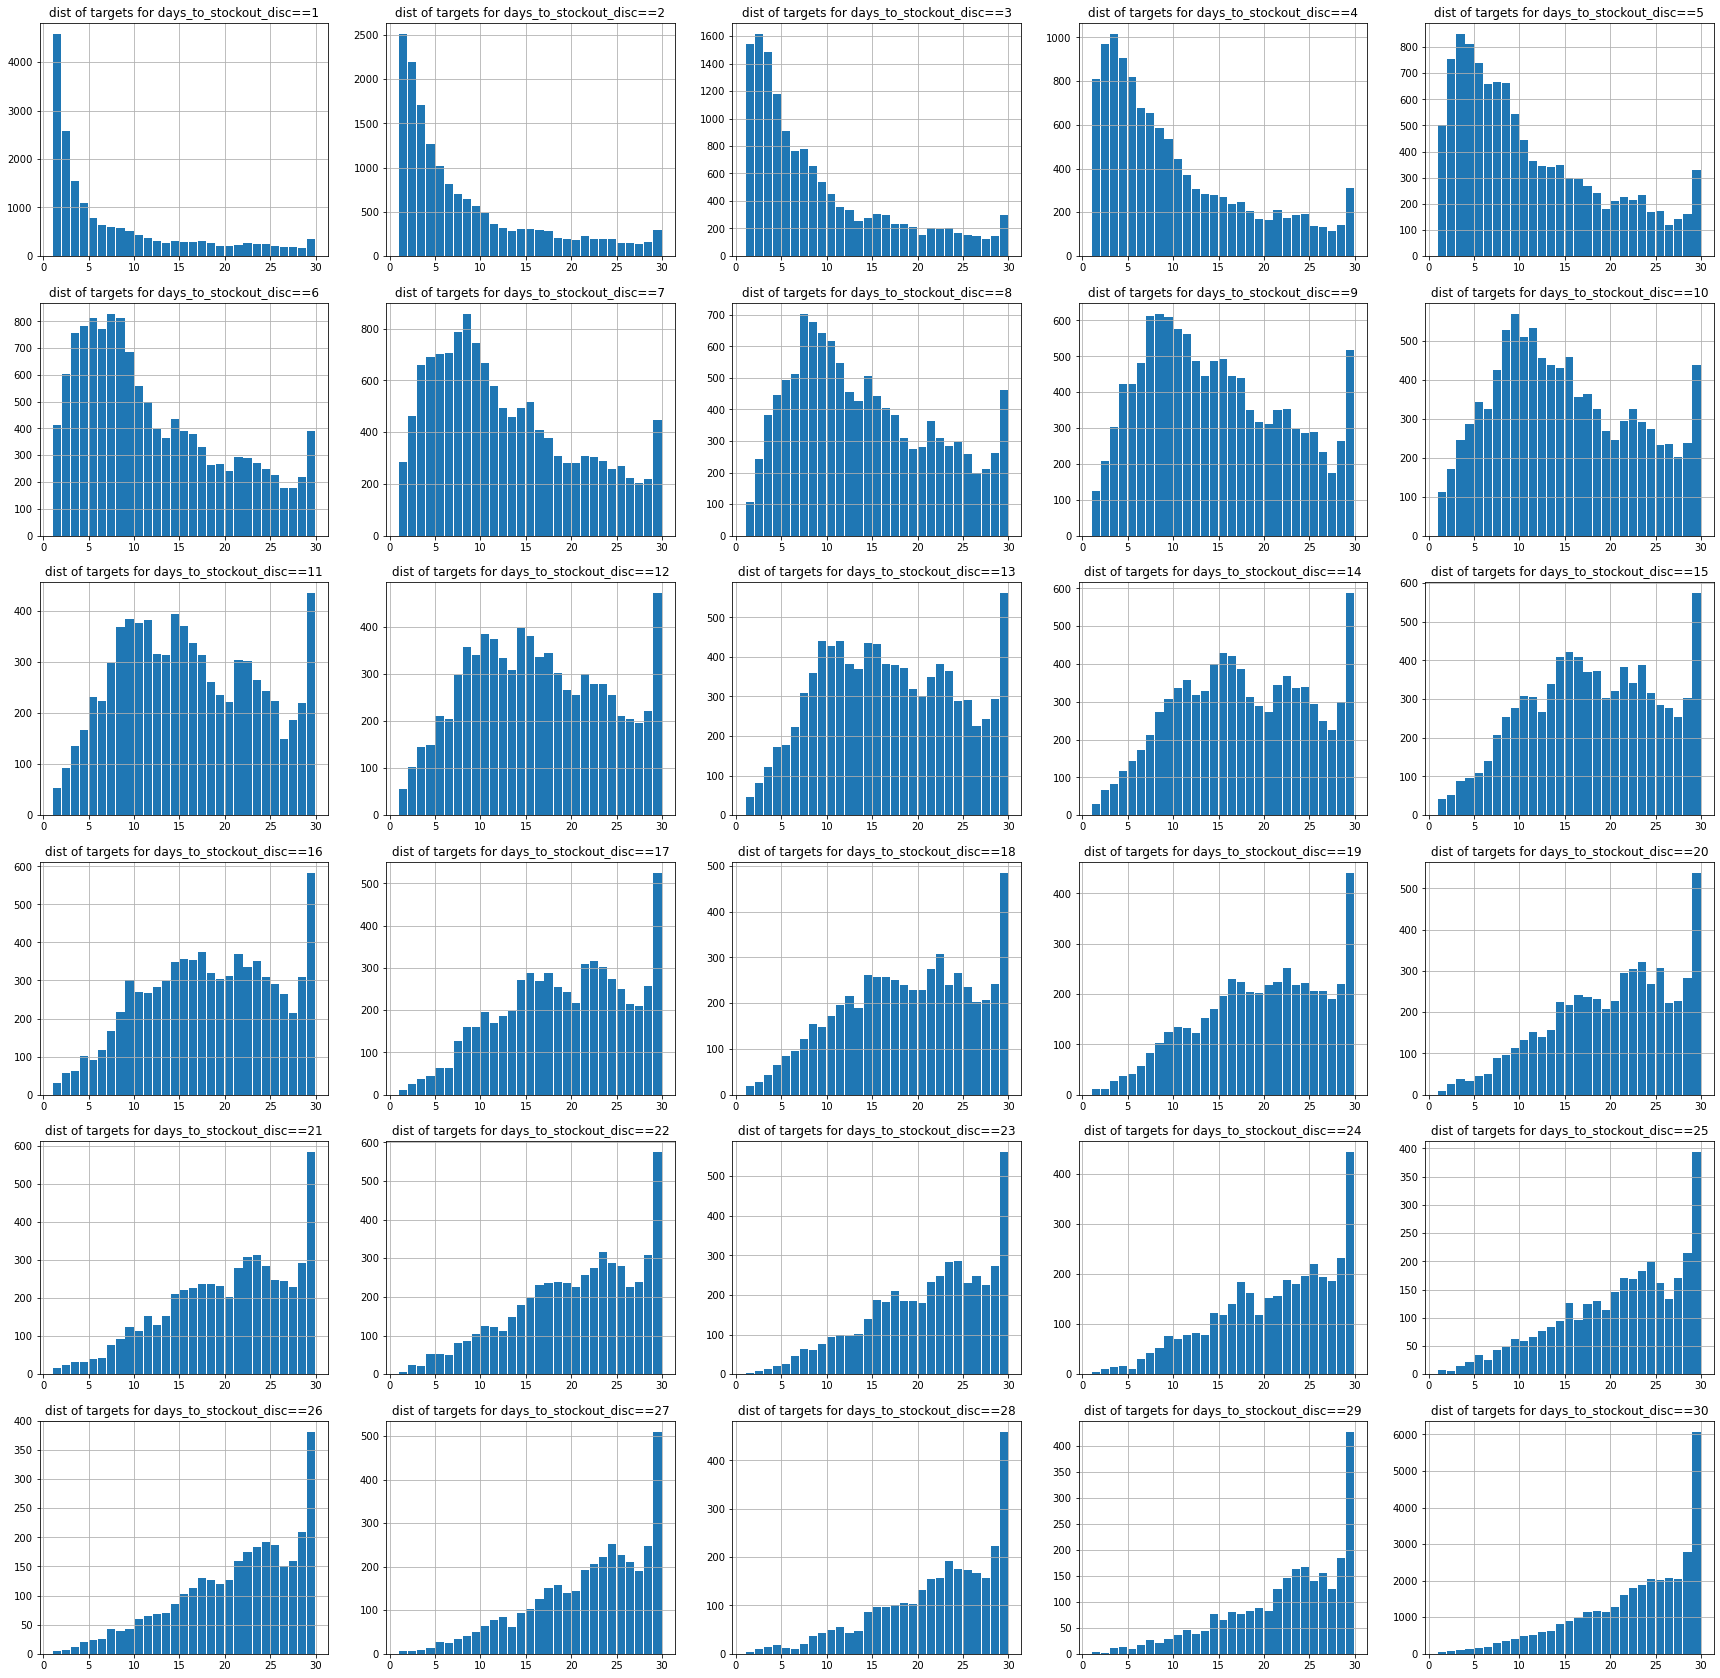

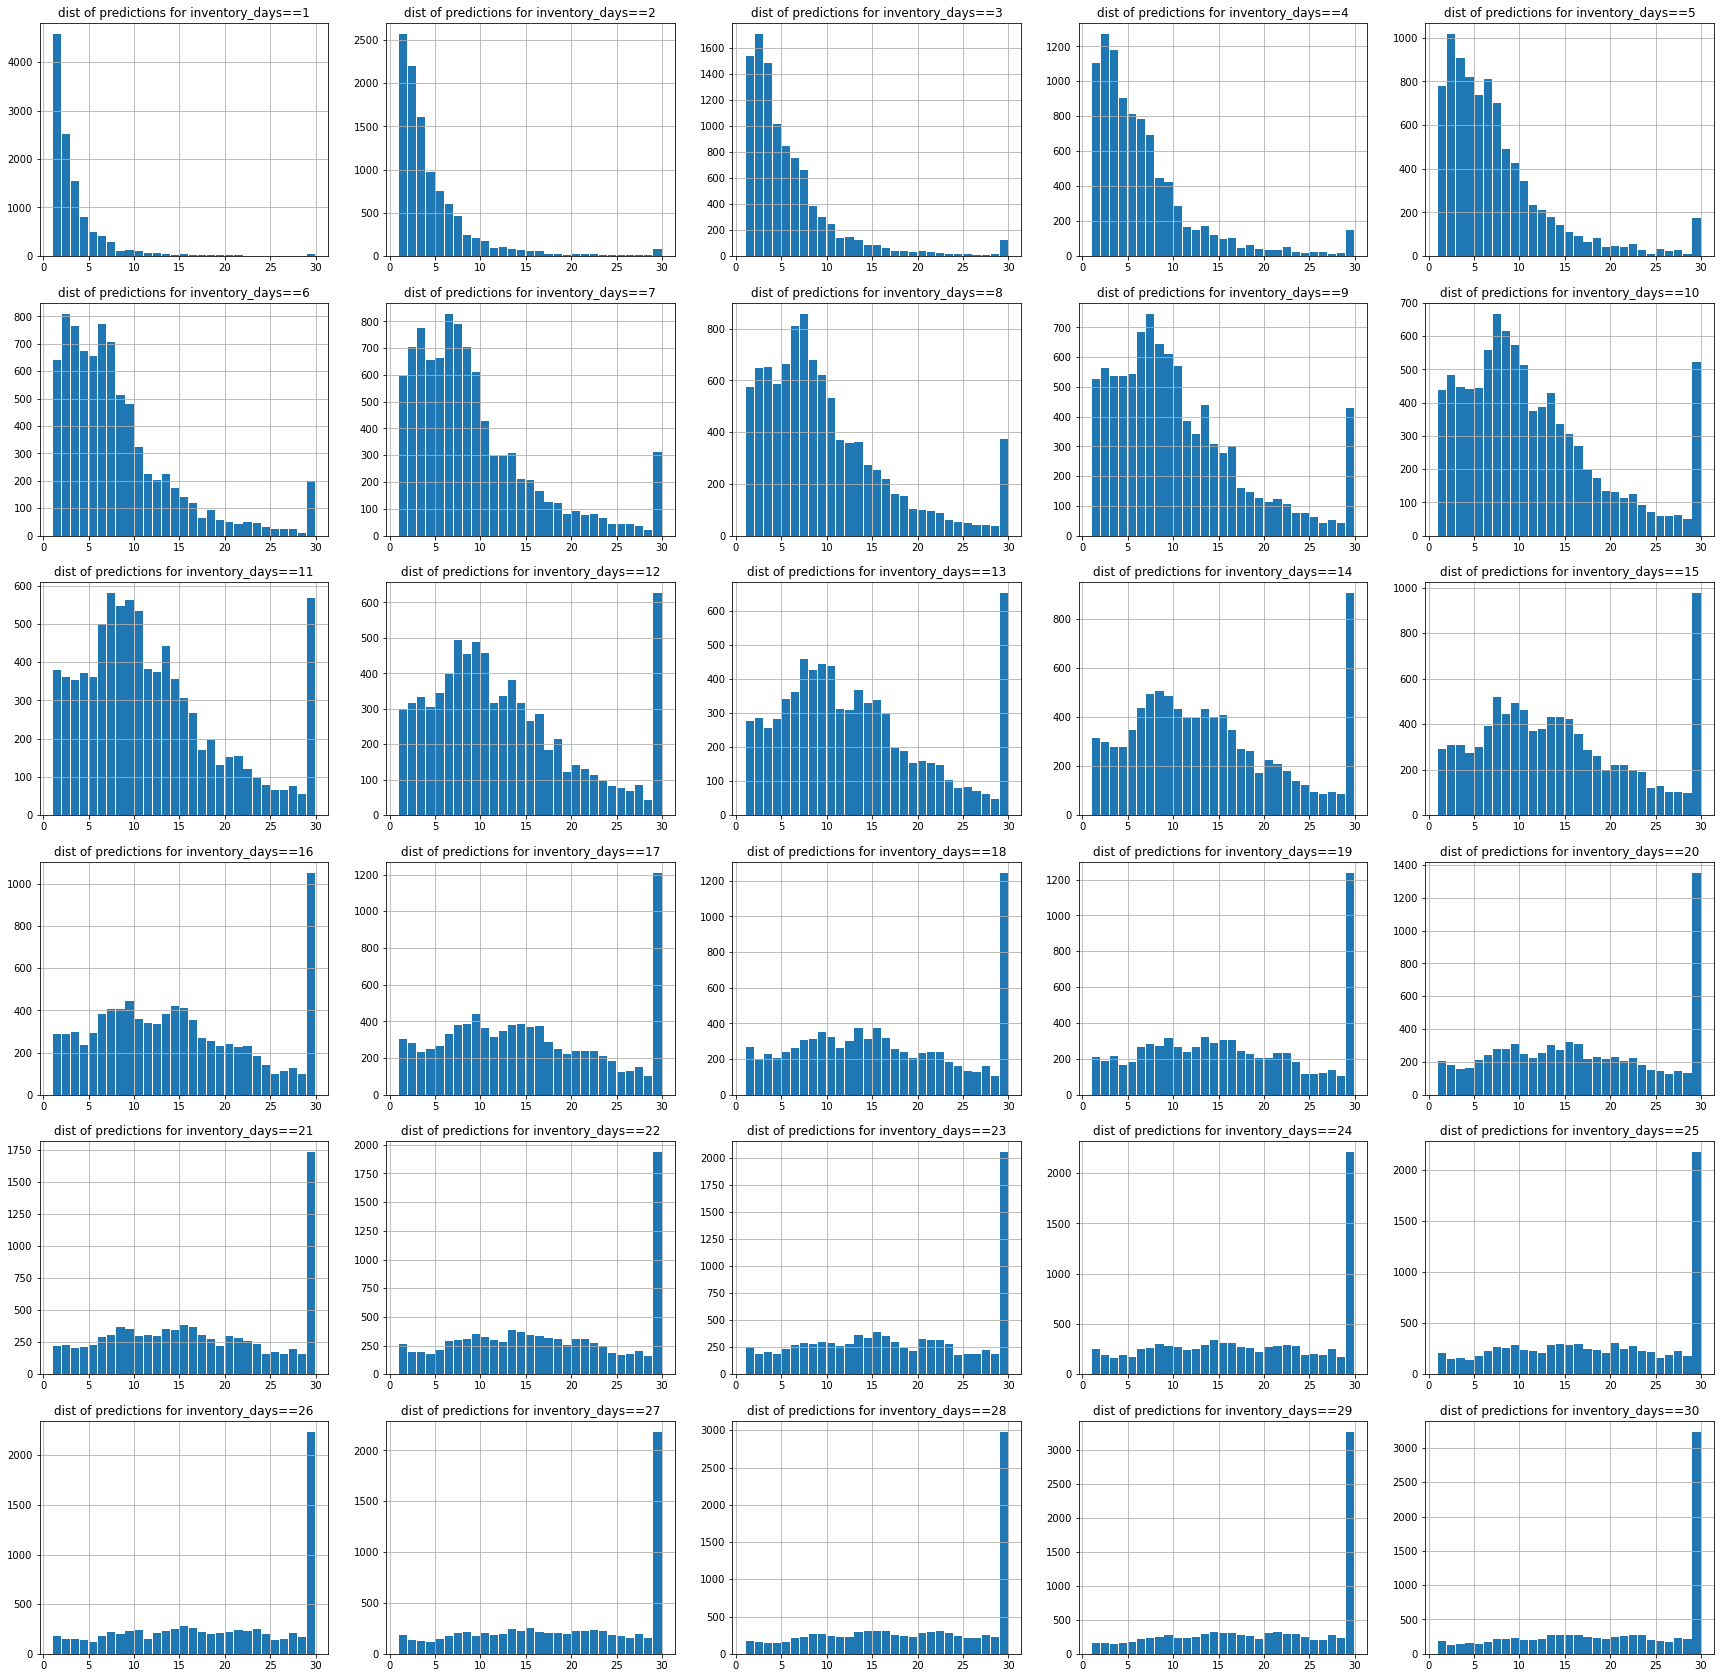

In [20]:
if ASSESS:
    print("RMSE (mean): ", np.sqrt(valid.query("sku in @skus_assess_m2").eval("(days_to_stockout - inventory_days)**2").mean()) )
    print("MAE (mean): ",  valid.query("sku in @skus_assess_m2").eval("abs(days_to_stockout - inventory_days)").mean() )
    print("MAE (median): ", valid.query("sku in @skus_assess_m2").eval("abs(days_to_stockout - inventory_days)").median() )
    print()
    
    plt.figure(figsize=(20,5))
    plt.hist(
        [valid.query("sku in @skus_assess_m2").inventory_days, 
         valid.query("sku in @skus_assess_m2").days_to_stockout,
        ],
        label=["target","predictions"],
        bins=np.arange(1,31,1),
        align="right",
        rwidth=0.8)
    plt.legend(loc="best")
    plt.grid()
    plt.show()
    print()
    
    plt.figure(figsize=(30,30))
    for d in range(1,31):
        plt.subplot(6, 5, d)
        plt.hist(valid.query("(days_to_stockout_disc == @d) & (sku in @skus_assess_m2)").inventory_days, bins=np.arange(1,31,1), rwidth=0.9)
        plt.title(f"dist of targets for days_to_stockout_disc=={d}")
        plt.grid()
    plt.show()
    print()
    
    plt.figure(figsize=(30,30))
    for d in range(1,31):
        plt.subplot(6, 5, d)
        plt.hist(valid.query("(inventory_days == @d) & (sku in @skus_assess_m2)").days_to_stockout, bins=np.arange(1,31,1), rwidth=0.9)
        plt.title(f"dist of predictions for inventory_days=={d}")
        plt.grid()
    plt.show()

***
## Assessment of RPS

In [21]:
if ASSESS:
    valid_files = [fn for fn in glob(f"{input_path}/validation_*.csv") if ("seed23" in fn or "real" in fn)]
    results = list()

    for files in valid_files:
        valid = (
            pd.read_csv(files)
            .query("sku in @skus_assess_m1")
            .query("inventory_days <= 30")
            .reset_index(drop=True)
        )
        valid["inventory_days"] = valid["inventory_days"].astype(int)
        
        preds_proba = list()
        for sku,df in tqdm(valid.groupby("sku")):
            preds_proba.append(predictor.predict_proba(
                sku, 
                stock=df.target_stock.values[0],
                lambda1=dist_config["lambda1"], 
                lambda2=dist_config["lambda2"],
                lambda3=dist_config["lambda3"],
                lambda4=dist_config["lambda4"],
            ))
        preds_proba = np.array(preds_proba)

        rps = scoring_function(valid.inventory_days.values, preds_proba)
        results.append({"file":files.split("/")[-1].split(".")[0], "rps":rps})
        print({"file":files.split("/")[-1].split(".")[0], "rps":rps})

100%|██████████| 482635/482635 [03:04<00:00, 2620.78it/s]


{'file': 'validation_seed23_harder', 'rps': 4.3820652060756435}


100%|██████████| 482635/482635 [02:56<00:00, 2734.71it/s]


{'file': 'validation_seed23', 'rps': 4.135199380158719}


100%|██████████| 324347/324347 [02:01<00:00, 2678.49it/s]


{'file': 'validation_realstock', 'rps': 3.923624621194985}


In [22]:
if ASSESS:
    display(pd.DataFrame(results))

,file,rps
0,validation_seed23_harder,4.382065
1,validation_seed23,4.135199
2,validation_realstock,3.923625


In [32]:
del model, predictor, dataset
gc.collect()

22

***
## model training

In [39]:
unpredictable = pd.read_csv(f"{input_path}/unpredictable.csv")
skus_for_test = pd.read_csv(f"{input_path}/test_data.csv").sku.values

dataset = (
    pd.read_parquet(f"{input_path}/train-m1.parquet")
    .query("sku not in @unpredictable.sku")
    .query("sku in @skus_for_test")
    .rename({"date":"ds", "sold_quantity":"y"}, axis=1,)
    .sort_values(["sku","ds"])
    .reset_index(drop=True)
)
print("nrows:", len(dataset)/1e6)
print("nskus:", dataset.sku.nunique())

with open("../encoders/encoder-stg2.dill", "rb") as file:
    encoder = dill.load(file)
    file.close()

transformed = encoder.transform(dataset[encoder.cols].astype("category"))
for col in transformed.columns:
    dataset[col+"_glm"] = transformed[col].values

nrows: 30.218397
nskus: 526158


In [40]:
test = (
    pd.read_parquet(f"{input_path}/test-m1.parquet")
    .query("sku not in @unpredictable.sku")
    .rename({"date":"ds",}, axis=1,)
    .sort_values(["sku","ds"])
    .assign(weight = None)
    .reset_index(drop=True)
)
print("nrows:", len(test)/1e6)
print("nskus:", test.sku.nunique())

transformed = encoder.transform(test[encoder.cols].astype("category"))
for col in transformed.columns:
    test[col+"_glm"] = transformed[col].values

nrows: 15.78474
nskus: 526158


In [41]:
# compute q_mean and q_std features (w/o leakage)
feat = Featurador(raw)
feat.fit(left_limit="2021-02-01", right_limit="2021-03-31")
dataset = feat.transform(dataset)
test = feat.transform(test)

In [42]:
min_weight = 0.1
scaler = preprocessing.MinMaxScaler(feature_range=(min_weight, 1))
dataset["weight"] = scaler.fit_transform(dataset["minutes_active"].values.reshape(-1,1)).ravel()

Mem. usage decreased to 3717.59 Mb (44.4% reduction)
Elapsed time for processing features: 2.975181301434835 min.
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Info] Total Bins 42261
[LightGBM] [Info] Number of data points in the train set: 30218397, number of used features: 21


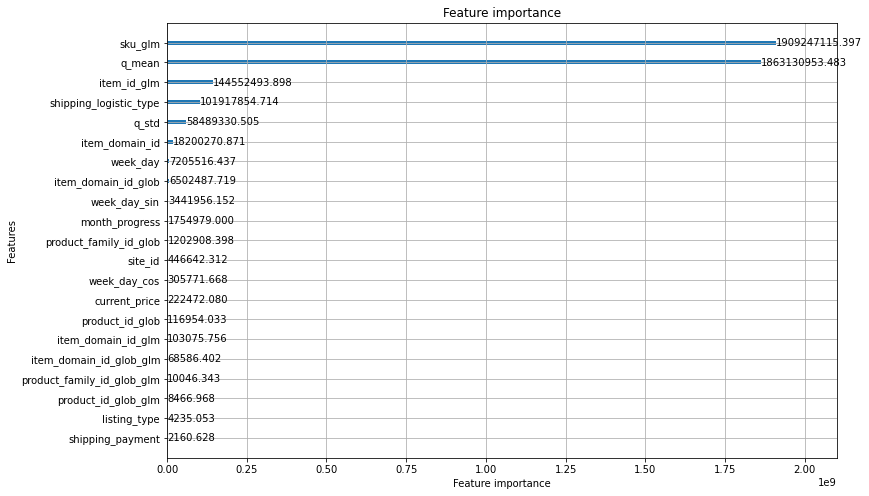

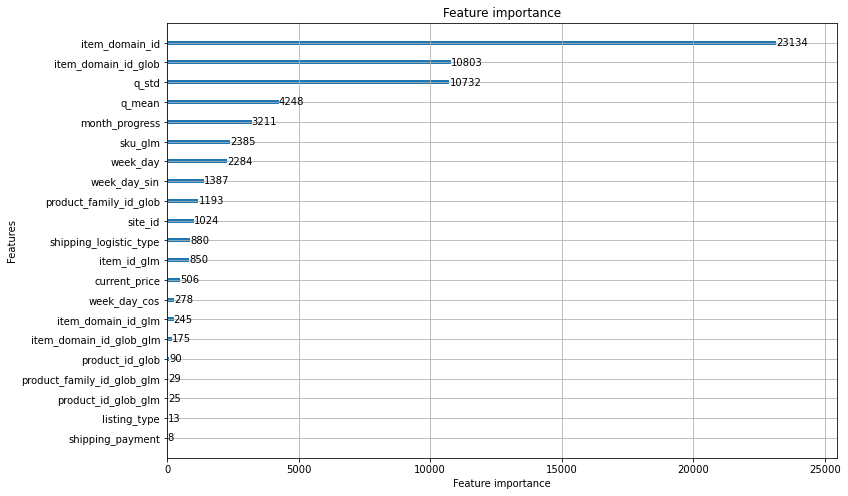

Elapsed time for training the model: 7.71174388329188 min.


In [43]:
tic = time.time()

_model_kwargs = dict(model_kwargs)
_model_kwargs["model_params"]["num_iterations"] = 250

model = LightGBMForecaster(**_model_kwargs)
model.prepare_features(dataset)
model.train_features = reduce_mem_usage(model.train_features, verbose=True)
gc.collect()
tac = time.time()
print(f"Elapsed time for processing features: {(tac-tic)/60} min.")

tic = time.time()
model.fit()
lgb.plot_importance(model.model.model, figsize=(12,8), importance_type="gain")
lgb.plot_importance(model.model.model, figsize=(12,8), importance_type="split")
plt.show()
tac = time.time()
print(f"Elapsed time for training the model: {(tac-tic)/60} min.")


In [44]:
predictions = model.predict(test, recursive=False)
predictions.to_csv(f"../results/preds_m1_lgbm_sub{SUB_NBR}.csv", index=False)

In [45]:
predictor = InventoryDaysPredictor(dataset)
predictor.fit(predictions)

100%|██████████| 526158/526158 [01:21<00:00, 6488.09it/s]


In [46]:
stockout_preds = list()
groups = (
    test[["sku","target_stock"]]
    .drop_duplicates()
    .groupby("sku")
)

for sku,df in tqdm(groups):
    stockout_preds.append(predictor.predict(sku, df.target_stock.values[0])[0])
stockout_preds = pd.DataFrame(stockout_preds, columns=["days_to_stockout"])

100%|██████████| 526158/526158 [01:24<00:00, 6247.53it/s]


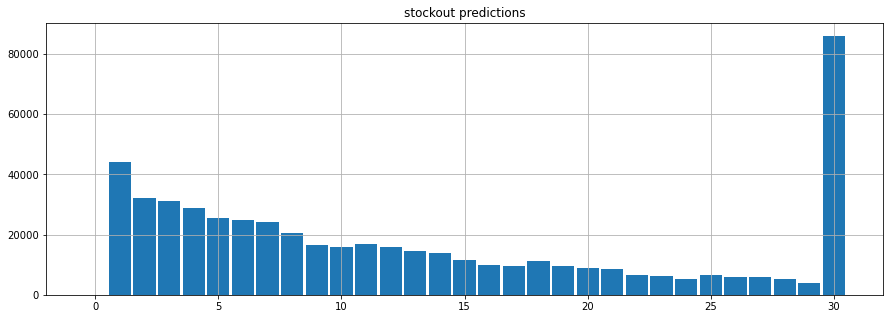

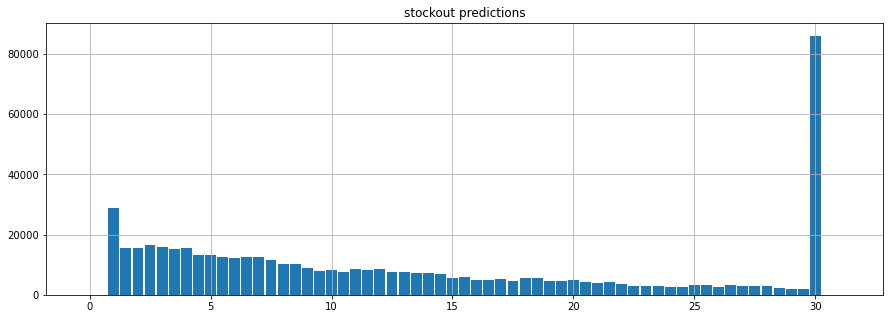

In [47]:
plt.figure(figsize=(15,5))
plt.hist(stockout_preds.days_to_stockout, bins=np.arange(0,32,1), rwidth=0.9, align='left')
plt.grid()
plt.title("stockout predictions")
plt.show()

plt.figure(figsize=(15,5))
plt.hist(stockout_preds.days_to_stockout, bins=np.arange(0,32,0.5), rwidth=0.9, align='left')
plt.grid()
plt.title("stockout predictions")
plt.show()

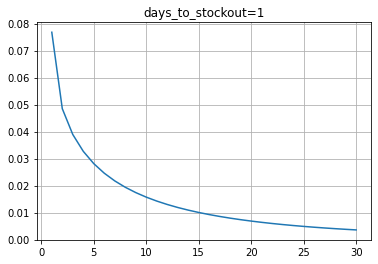

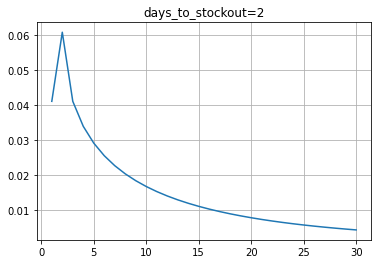

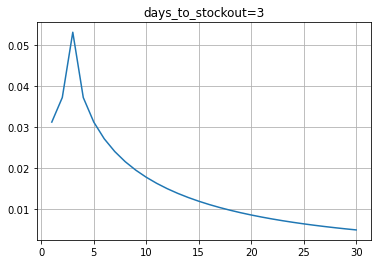

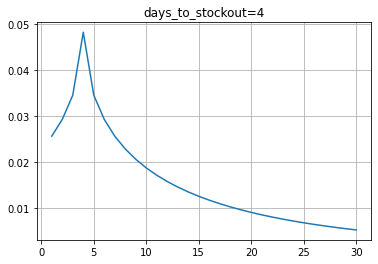

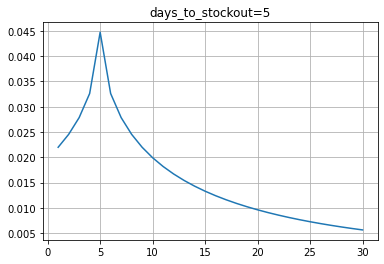

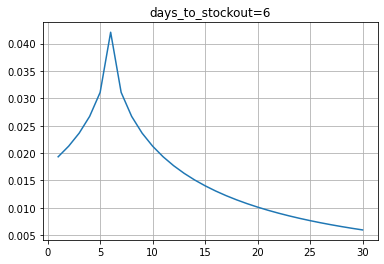

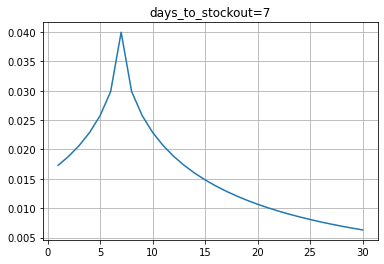

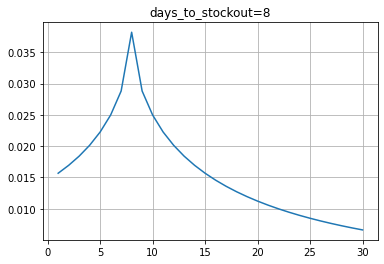

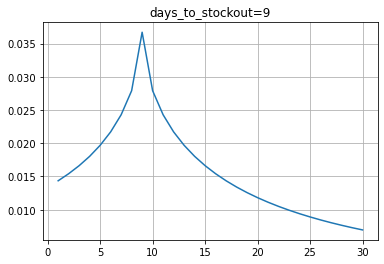

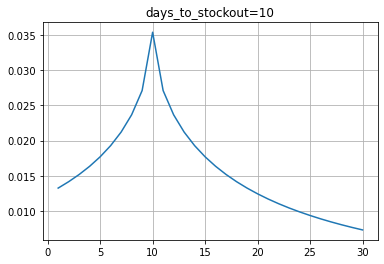

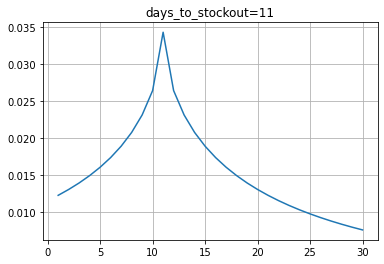

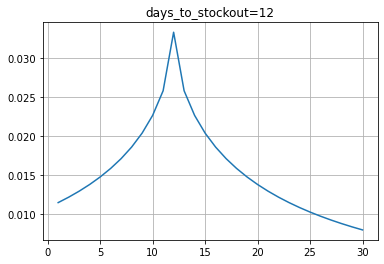

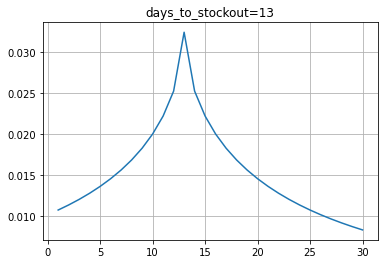

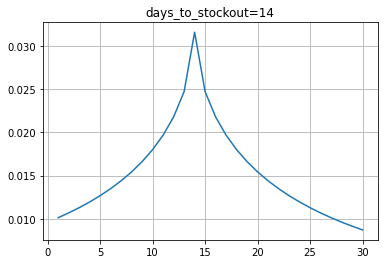

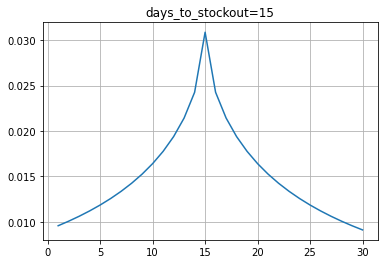

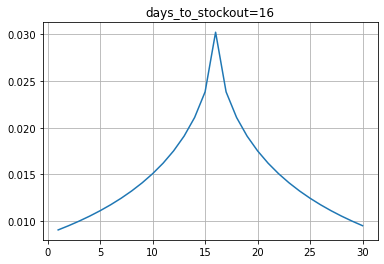

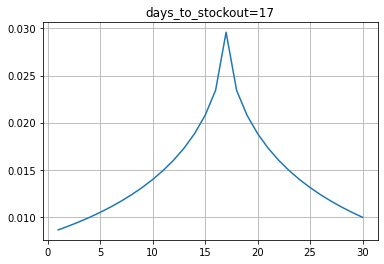

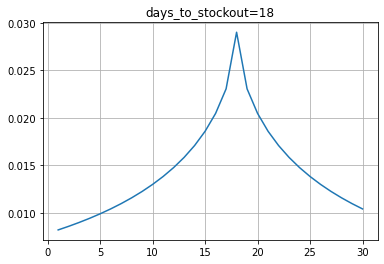

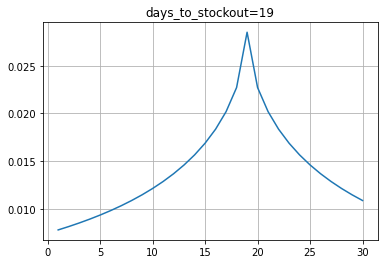

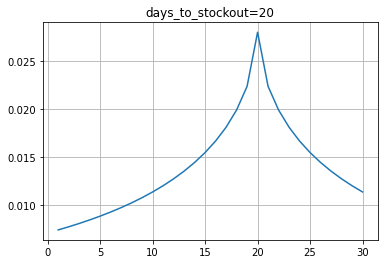

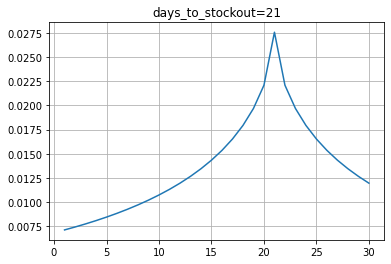

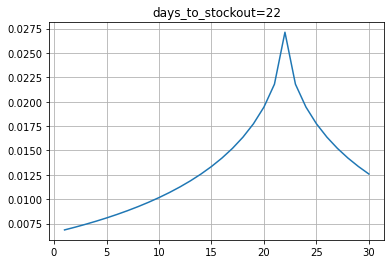

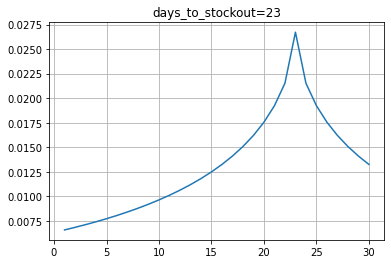

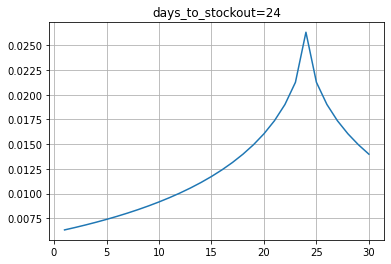

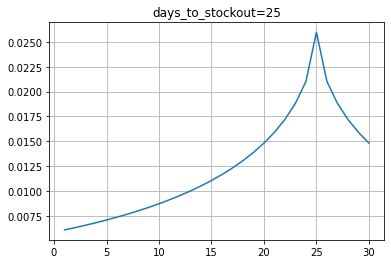

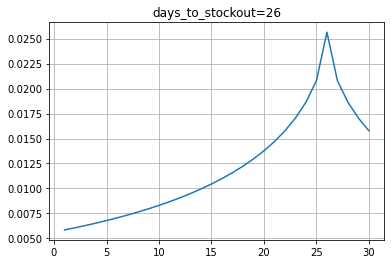

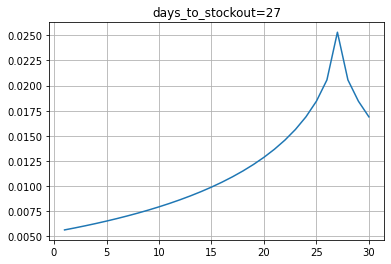

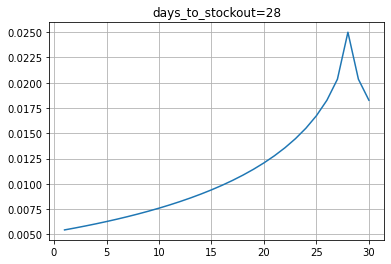

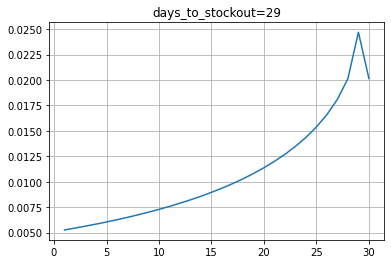

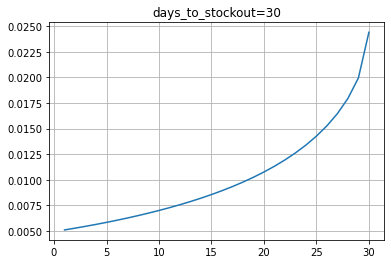

In [48]:
std_days = np.mean(np.asarray(list(predictor.parameters["std"].values())) / np.asarray(list(predictor.parameters["mean"].values())))

for days_to_stockout in range(1,31):
    scale = std_days * (dist_config["lambda1"]*(days_to_stockout**dist_config["lambda2"]))
    beta = dist_config["lambda3"]*(days_to_stockout**dist_config["lambda4"])
    days = np.arange(1,31)
    probs = stats.gennorm.pdf(days, loc=days_to_stockout, scale=scale, beta=beta)
    
    plt.plot(days, probs)
    plt.grid()
    plt.title(f"days_to_stockout={days_to_stockout}")
    plt.show()

In [49]:
# skus = list()
# preds_proba = list()
# groups = (
#     test[["sku","target_stock"]]
#     .drop_duplicates()
#     .groupby("sku")
# )

# for sku,df in tqdm(groups):
#     skus.append(sku)
#     preds_proba.append(predictor.predict_proba(
#         sku, 
#         stock=df.target_stock.values[0],
#         lambda1=dist_config["lambda1"], 
#         lambda2=dist_config["lambda2"],
#         lambda3=dist_config["lambda3"],
#         lambda4=dist_config["lambda4"],
#     ))
# preds_proba = np.array(preds_proba)
# preds_proba = pd.DataFrame(preds_proba, index=skus)

In [50]:
# unpreds_proba = np.ones((len(unpredictable),30)) / 30
# unpreds_proba = pd.DataFrame(unpreds_proba, index=unpredictable.sku.values)

# preds_proba_mrg = pd.concat([preds_proba, unpreds_proba])
# preds_proba_mrg

***
## generate submission

In [51]:
# test = pd.read_csv(f"{input_path}/test_data.csv")
# preds_proba_mrg = preds_proba_mrg.loc[test.sku.values,:].copy()

In [52]:
# assert preds_proba_mrg.isna().sum(axis=1).sum() == 0
# assert np.allclose(preds_proba_mrg.sum(axis=1).values, 1, atol=1e-16)
# assert preds_proba_mrg.max(axis=1).max() < 1

In [53]:
# (preds_proba_mrg
#  .round(4)
#  .to_csv(f"{subs_path}/sub{SUB_NBR}.csv.gz", header=False, index=False, compression="gzip")
# )

***